# Settings

Change **PATH_SYNTHETIC**, poiting to the synthetic dataset root (eg folder containing train/val/test) from project root.%

In [2]:
import numpy as np
from PIL import Image, ImageFilter
from noise import snoise2
import random
from os.path import expanduser as os_path_expanduser, join as os_path_join, isdir as os_path_isdir, \
    exists as os_path_exists, splitext as os_path_splitext
from os import listdir as os_listdir, makedirs as os_makedirs, remove as os_remove
import scipy.ndimage
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import tifffile

PATH_SYNTHETIC = '../data/synthetic'
os_makedirs(PATH_SYNTHETIC, exist_ok=True)
os_makedirs(os_path_join(PATH_SYNTHETIC, 'train'), exist_ok=True)
os_makedirs(os_path_join(PATH_SYNTHETIC, 'val'), exist_ok=True)
PATH_SYNTHETIC_TRAIN = os_path_join(PATH_SYNTHETIC, 'train')
PATH_SYNTHETIC_VAL = os_path_join(PATH_SYNTHETIC, 'val')
PATH_SYNTHETIC_TEST = os_path_join(PATH_SYNTHETIC, 'test')
os_makedirs(PATH_SYNTHETIC_TEST, exist_ok=True)

for d in [PATH_SYNTHETIC_TRAIN, PATH_SYNTHETIC_VAL]:
    os_makedirs(os_path_join(d, 'images'), exist_ok=True)
    os_makedirs(os_path_join(d, 'labels'), exist_ok=True)


# Path to slippers masks, later filled with random noise to look as cells
PATH_SLIPPERS = os_path_join(PATH_SYNTHETIC, 'slippers', 'masks')

# Utils

In [24]:
def upscale_mask(mask: np.ndarray, scale: float = 2.0, smooth: bool = True) -> np.ndarray:
    """
    Upscales a binary mask by a given scale factor while preserving smooth contours.

    Args:
        mask (np.ndarray): Binary mask to upscale.
        scale (float): Upscaling factor (e.g., 2.0 = 2x bigger).
        smooth (bool): If True, apply Gaussian blur to smooth edges after upscaling.

    Returns:
        np.ndarray: Upscaled binary mask.
    """
    # Resize using INTER_CUBIC for smooth interpolation
    h, w = mask.shape[:2]
    new_size = (int(w * scale), int(h * scale))
    resized = cv2.resize(mask, new_size, interpolation=cv2.INTER_CUBIC)

    # Smoothing to reduce jagged edges
    if smooth:
        blurred = cv2.GaussianBlur(resized, (5, 5), sigmaX=1)
        _, smoothed_mask = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
        return smoothed_mask.astype(np.uint8)
    
    return (resized > 127).astype(np.uint8) * 255

# Random Background

Function to create a microdevice-looking background.

In [3]:
def generate_noise_background(width, height):
    # Step 1: Random base background color
    base_color = random.randint(50, 180)
    base_image = np.full((height, width), base_color, dtype=np.float32)

    # Step 2: Add first Simplex noise with random zoom level
    zoom1 = random.uniform(0.5, 2.0)
    noise1 = np.array([[snoise2(x / zoom1, y / zoom1) for x in range(width)] for y in range(height)])
    noise1 = (noise1 - noise1.min()) / (noise1.max() - noise1.min())  # Normalize to (0,1)
    base_image += noise1 * random.uniform(0.5, 2.0)

    # Step 3: Apply Gaussian blur with a random radius
    img = Image.fromarray(np.uint8(base_image))
    blur_radius = random.uniform(1.0, 3.0)
    img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    # Step 4: Add second Simplex noise with randomized intensity
    zoom2 = random.uniform(0.5, 3.0)
    noise2 = np.array([[snoise2(x / zoom2, y / zoom2) for x in range(width)] for y in range(height)])
    noise2 = noise2 * random.uniform(-20, 20)  # Random scale range
    img_array = np.array(img, dtype=np.float32) + noise2

    # Step 5: Add third Simplex noise with a different zoom and intensity
    zoom3 = random.uniform(0.005, 0.02)
    noise3 = np.array([[snoise2(x * zoom3, y * zoom3) for x in range(width)] for y in range(height)])
    noise3 = noise3 * random.uniform(-10, 10)
    img_array += noise3

    # Clip and convert back to image
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    final_image = Image.fromarray(img_array)

    return final_image

# Cell creation

The following functions creates random cells from scratch using simplex noise and gaussian blur.



## First: elastic deformation

Schematic effect below. Image from Rademaker, D. T., Koopmans, J. J., Thyen, G. M. S. M., Piruska, A., Huck, W. T. S., Vriend, G., ‘t Hoen, P. A. C., Kooij, T. W. A., Huynen, M. A., & Proellochs, N. I. (2023). Quantifying the deformability of malaria-infected red blood cells using deep learning trained on synthetic cells. iScience, 26(12), 108542. https://doi.org/10.1016/j.isci.2023.108542

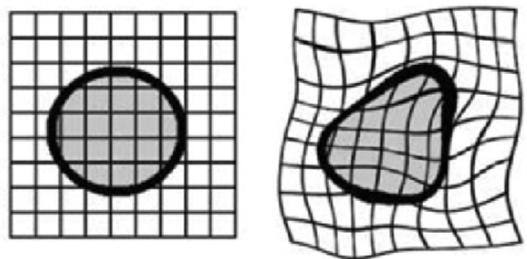

In [3]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Apply elastic deformation on an image."""
    if random_state is None:
        random_state = np.random.RandomState(None)
    shape = image.shape[:2]

    # generate random displacement fields
    dx = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
    dy = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha

    # meshgrid coordinates
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    # map coordinates with linear interpolation
    distorted = scipy.ndimage.map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    return distorted

## Round cells - deformed

In [4]:
def generate_cell_image(width, height, r_outer = 16, r_mid = 14, r_inner = 13):
    """
    Creates a random sized cell and use an inner texture using Simplex and
    gaussian blur.

    Parameters
    ----------
    width: int
        width of output image (background+cell)
    height: int
        width of output image (background+cell)

    Returns
    -------
    np.array
        background with cell overlayed, size (height, width)
    np.array
        binary mask for the cell, size (height, width)
    """
    # Create blank image
    background = np.full((height, width), random.randint(65, 146), dtype=np.uint8)

    # Define cell properties
    cx, cy = width // 2, height // 2  # Center position
    #r_outer = 16
    #r_mid = 14
    #r_inner = 13
    thickness_outer = random.randint(1, 4)
    thickness_mid = random.randint(1, 3)

    # Create a blank cell image
    cell = np.zeros((height, width), dtype=np.uint8)

    # Draw outer circle
    color_outer = random.randint(110, 250)
    cv2.circle(cell, (cx, cy), r_outer, color_outer, thickness_outer)

    # Draw middle black circle
    cv2.circle(cell, (cx, cy), r_mid, 0, thickness_mid)

    # Draw inner filled circle
    cv2.circle(cell, (cx, cy), r_inner, 70, -1)

    # Generate Simplex noise texture
    noise_choice = random.choice([(50, 100), (0, 220)])
    zoom = 0.2
    noise_texture = np.array([[snoise2(x * zoom, y * zoom) for x in range(width)] for y in range(height)])
    noise_texture = np.interp(noise_texture, (noise_texture.min(), noise_texture.max()), noise_choice)

    # Apply noise texture inside the cell
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.circle(mask, (cx, cy), r_inner, 255, -1)  # Mask for inner circle
    cell = np.where(mask == 255, noise_texture, cell)

    alpha = 200
    sigma = random.choice([8, 12])
    cell = elastic_transform(cell, alpha, sigma)

    # Convert to PIL Image and apply Gaussian blur
    cell_img = Image.fromarray(cell.astype(np.uint8))
    cell_img = cell_img.filter(ImageFilter.GaussianBlur(radius=1.5))

    # Overlay the cell onto the background
    background = Image.fromarray(background)
    background.paste(cell_img, (0, 0), mask=cell_img)

    return np.array(background), cell > 0

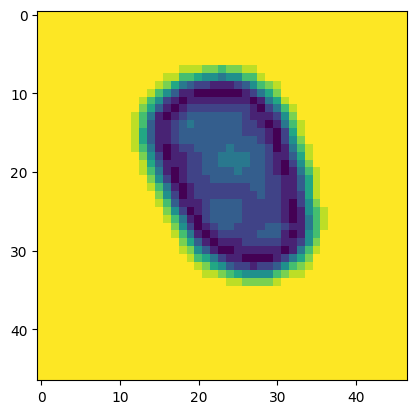

In [26]:
plt.imshow(generate_cell_image(47, 47)[0])

## Bullet/Parachute cells

In [6]:
def generate_bullet_cell(cell_canvas_size=(128, 128), rotation_angle=30,
                         outer_a=16, outer_b=12, inner_r=14,
                         offset_lim=(-10, -5)):
    r"""
    Generate a bullet-cell with modified curvature:
      - Outer arc: drawn as a half-ellipse (more curved) over -90° to 90°.
      - Inner arc: drawn over a third of a circle (less curved), e.g., from -30° to 30°.
      - Both arcs are drawn as right-half curves (like ')' shapes) with a horizontal offset.
      - Their endpoints are connected by lines (extended left by [0,5] pixels).
      - The shape is filled either uniformly or with a Simplex noise texture,
        then blurred, deformed, rotated, and overlaid on a background.

    Note: /!\ Scale of the cell is invariant to the cell of the canvas. On
    small canvas, a modification of radius is needed to scale cells.

    Parameters
    ----------
    cell_canvas_size: tuple(int, int)
        width, height of cell's full image

    rotation_angle: int
        final cell will be rotated between -angle and + angle.

    outer_a : int
      outer arc horizontal radius

    outer_b :int
      outer arc vertical radius (different from outer_a gives an ellipse)
    
    inner_r: int
      radius for inner arc (Parameters for inner (less curved) arc (circle segment))

    offset_lim: tuple(int, int)
      random min and max
      Horizontal offset for inner arc center relative to outer arc center.

    Returns
    -------
    cell_rotated: np array
      array representing the rotated bullet cell
    -------
    """
    cell_img = np.zeros((cell_canvas_size[1], cell_canvas_size[0]), dtype=np.uint8)
    w, h = cell_canvas_size
    cx, cy = w // 2, h // 2

    # Parameters for outer (elliptical) arc
    #outer_a = 16  # horizontal radius
    #outer_b = 12  # vertical radius (different from outer_a gives an ellipse)
    # Parameters for inner (less curved) arc (circle segment)
    #inner_r = 14  # radius for inner arc

    # Horizontal offset for inner arc center relative to outer arc center.
    offset = random.randint(offset_lim[0], offset_lim[1])
    outer_center = (cx, cy)
    inner_center = (cx + offset, cy)

    # Outer arc: use full half range from -90° to 90° for an ellipse.
    num_points_outer = 50
    theta_outer = np.linspace(-np.pi/2, np.pi/2, num_points_outer)
    outer_arc = [(int(outer_center[0] + outer_a * np.cos(t)),
                   int(outer_center[1] + outer_b * np.sin(t))) for t in theta_outer]

    # Inner arc: only draw a segment (e.g., from -30° to 30°) to make it less curved.
    num_points_inner = 30
    theta_inner = np.linspace(-np.pi/6, np.pi/6, num_points_inner)  # -30° to 30°
    inner_arc = [(int(inner_center[0] + inner_r * np.cos(t)),
                   int(inner_center[1] + inner_r * np.sin(t))) for t in theta_inner]

    # Identify endpoints for both arcs.
    outer_top, outer_bot = outer_arc[0], outer_arc[-1]
    inner_top, inner_bot = inner_arc[0], inner_arc[-1]

    # Extend the endpoints to the left by a random extension in [0,5] pixels.
    ext = random.randint(0, 5)
    outer_top_ext = (outer_top[0] - ext, outer_top[1])
    outer_bot_ext = (outer_bot[0] - ext, outer_bot[1])
    inner_top_ext = (inner_top[0] - ext, inner_top[1])
    inner_bot_ext = (inner_bot[0] - ext, inner_bot[1])

    # Construct the bullet shape polygon:
    # Start with the outer arc (top to bottom),
    # then connect outer_bot_ext to inner_bot_ext,
    # add the inner arc in reverse (bottom to top),
    # and finally connect inner_top_ext back to outer_top_ext.
    poly_points = []
    poly_points.extend(outer_arc)
    poly_points.append(outer_bot_ext)
    poly_points.append(inner_bot_ext)
    poly_points.extend(reversed(inner_arc))
    poly_points.append(inner_top_ext)
    poly_points.append(outer_top_ext)
    poly_points = np.array(poly_points, dtype=np.int32)

    # Create a mask from the polygon.
    cell_mask = np.zeros_like(cell_img)
    cv2.fillPoly(cell_mask, [poly_points], 255)

    # Decide fill type: uniform or with Simplex noise texture.
    cell_fill = np.zeros_like(cell_img, dtype=np.uint8)
    use_texture = random.choice([True, False])
    if use_texture:
        zoom = 0.2
        noise_min, noise_max = random.choice([(50, 100), (0, 220)])
        noise_arr = np.zeros(cell_img.shape, dtype=np.float32)
        for y in range(h):
            for x in range(w):
                noise_arr[y, x] = snoise2(x * zoom, y * zoom)
        noise_arr = np.interp(noise_arr, (noise_arr.min(), noise_arr.max()), (noise_min, noise_max))
        cell_fill = noise_arr.astype(np.uint8)
    else:
        cell_fill[:] = random.randint(85, 140)

    # Apply the fill only inside the bullet shape.
    cell_shape = np.where(cell_mask == 255, cell_fill, 0).astype(np.uint8)

    # Draw outlines for the arcs with thickness=2 (using black color).
    cv2.polylines(cell_shape, [np.array(outer_arc, dtype=np.int32)], isClosed=False, color=random.randint(60, 100), thickness=2)
    cv2.polylines(cell_shape, [np.array(inner_arc, dtype=np.int32)], isClosed=False, color=random.randint(60, 100), thickness=2)

    # Apply Gaussian blur with a kernel size of (9,9).
    cell_blurred = cv2.GaussianBlur(cell_shape, (9, 9), 0)

    # Apply elastic deformation with a=400 and sigma=17.
    cell_deformed = elastic_transform(cell_blurred, alpha=400, sigma=17)

    # Rotate the cell by a random angle in [-X, X] degrees.
    angle = random.randint(-rotation_angle, rotation_angle)
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    cell_rotated = cv2.warpAffine(cell_deformed, M, (w, h), borderMode=cv2.BORDER_CONSTANT) #cv2.BORDER_REFLECT)

    return cell_rotated

## Slipper cells

In [25]:
def get_circular_component(mask, circularity_threshold=0.7):
    """
    Get the roughfly circle perimeter of a binary mask representing a cell.
    Used then to plot this contour as white (to give some highlights to the images).
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best_component = None
    best_circularity = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 10:  # Skip small noise
            continue
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > circularity_threshold and circularity > best_circularity:
            best_circularity = circularity
            best_component = cnt
    return best_component, best_circularity

def fill_mask_with_slipper(mask:np.ndarray, rotation_angle:int=180):
    """
    Fill a mask defining the slipper cell with a random color or with Noise.
    Mask should come from data/synthetic/slippers/masks
    """
    cell_fill = np.zeros_like(mask, dtype=np.uint8)
    use_texture = random.choice([True, False])
    h, w = mask.shape
    if use_texture:
        zoom = 0.2
        noise_min, noise_max = random.choice([(50, 100), (0, 220)])
        noise_arr = np.zeros(mask.shape, dtype=np.float32)
        for y in range(h):
            for x in range(w):
                noise_arr[y, x] = snoise2(x * zoom, y * zoom)
        noise_arr = np.interp(noise_arr, (noise_arr.min(), noise_arr.max()), (noise_min, noise_max))
        cell_fill = noise_arr.astype(np.uint8)
    else:
        cell_fill[:] = random.randint(85, 140)

    # Apply the fill only inside the bullet shape.
    cell_shape = np.where(mask == 255, cell_fill, 0).astype(np.uint8)

    # Draw outlines for the arcs with thickness=2 (using black color).
    contour, _ = get_circular_component(mask, circularity_threshold=.3)
    cv2.polylines(cell_shape, [np.array(contour, dtype=np.int32)], isClosed=False, color=random.randint(60, 100), thickness=1)

    # Apply Gaussian blur with a kernel size of (9,9).
    cell_blurred = cv2.GaussianBlur(cell_shape, (9, 9), 0)

    # Apply elastic deformation with a=400 and sigma=17.
    cell_deformed = elastic_transform(cell_blurred, alpha=100, sigma=10) # barely noticeable

    # Rotate the cell by a random angle in [-X, X] degrees.
    angle = random.randint(-rotation_angle, rotation_angle)
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    cell_rotated = cv2.warpAffine(cell_deformed, M, (w, h), borderMode=cv2.BORDER_CONSTANT) #cv2.BORDER_REFLECT)

    return cell_rotated

# Overlay on background

Cells are placed randomly on the generated canvas.

`find_bounding_box` is used to get generated-cell size, to then place it appropriatly on the background.

In [8]:
def find_bounding_box(arr):
    """
    Finds the bounding box of the nonzero region in a binary or grayscale array.

    Returns:
    --------
    tuple: (x_min, y_min, x_max, y_max)
        The bounding box.
    """
    rows = np.any(arr, axis=1)
    cols = np.any(arr, axis=0)

    rmin, rmax = np.where(rows)[0][[0, -1]] # Finds the minx/max rows
    cmin, cmax = np.where(cols)[0][[0, -1]] # Finds the min/max columns

    #return rmin, rmax+1, cmin, cmax+1  # +1 to include the max index
    return cmin, rmin, cmax+1, rmax+1  # +1 to include the max index

def random_displace(arr):
    """
    Randomly displaces an object in a 2D numpy array.
    'r' variables: row
    'c' variables: column

    Parameters
    ----------
    arr: np.array
        Array representing the cell, with black background,
        and non-black pixels for the cell.

    Returns
    -------
    new_arr: np.array
        Same shape as arr, yet with the content of the input
        being randomly placed elsewhere.
    tuple: (x, y)
        min column and min row of new placement in the `arr`
        coord system.
    """

    # Find bounding box
    cmin, rmin, cmax, rmax = find_bounding_box(arr)

    # Extract the object
    obj = arr[rmin:rmax, cmin:cmax]

    # Determine new random position (top-left point of cell)
    max_r = arr.shape[0] - (rmax - rmin)
    max_c = arr.shape[1] - (cmax - cmin)
    new_rmin = np.random.randint(0, max_r) if max_r > 0 else 0
    new_cmin = np.random.randint(0, max_c) if max_c > 0 else 0

    # Create new empty array
    new_arr = np.zeros_like(arr)

    # Determine final placement (bottom-right point of cell)
    new_rmax = min(new_rmin + (rmax - rmin), arr.shape[0])
    new_cmax = min(new_cmin + (cmax - cmin), arr.shape[1])

    # Place object in new location (cropping if necessary)
    new_arr[new_rmin:new_rmax, new_cmin:new_cmax] = obj[:new_rmax - new_rmin, :new_cmax - new_cmin]


    return new_arr, (new_cmin, new_rmin, new_cmax, new_rmax)


def overlay_cell_on_background(cell_img, background, threshold=50):
    r"""
    Overlay the cell image on the background.
    /!\ If they have different shapes, both input must be square. Rectangles are
    allowed only if both cell and background have same shape.
    """

    # Pad to cell array to match the background sizes while
    # keeping the cell at the center of its array (center of background).
    if background.shape[0] != cell_img.shape[0]:
        cell_pad = np.pad(
            cell_img, (background.shape[0] - cell_img.shape[0])//2, mode='constant', constant_values=0
        )
    else:
        cell_pad = cell_img
    assert cell_pad.shape == background.shape, 'Padded cell should have same shape as background'

    # Displace the cell randomly on the background
    cell_f, cell_pos_on_background = random_displace(cell_pad)

    background_f = background.astype(np.float32)
    #cell_f = cv2.resize(cell_img, bg_size, interpolation=cv2.INTER_LINEAR).astype(np.float32)
    mask = (cell_f > threshold).astype(np.float32)

    blended = background_f * (1 - mask) + cell_f * mask
    #blended = np.where(cell_f < 100, background_f, cell_f)
    blended = np.clip(blended, 0, 255).astype(np.uint8)

    return blended, cell_pos_on_background

Example usage:

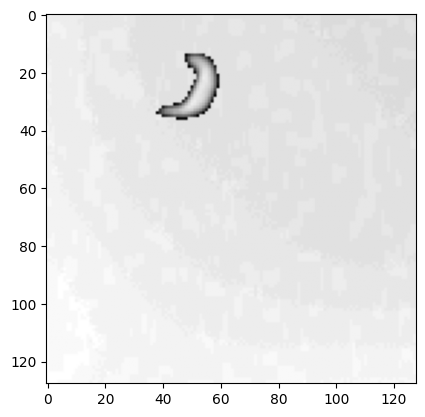

In [9]:
background = np.array(generate_noise_background(128, 128))
cell = generate_bullet_cell()
image, _ = overlay_cell_on_background(cell, background)

plt.imshow(Image.fromarray(image), cmap='gray');
Image.fromarray(image).show()

# Noise functions

Implement different noise methods :
- gaussian noise with custom mean and std (default 0, 0.1)
- [salt and pepper noise](https://www.sciencedirect.com/science/article/pii/B9780121197926500875)
- random noise (uniform 0.3)

In [10]:
def add_gaussian_noise(image, mean=0, std=.1):
    """
    Parameters
    ----------
    image: ndarray
        Pixels range [0, 1]

    Returns
    -------
    noisy image: ndarray
        Pixels range [0, 1]
    """
    # Generate Gaussian noise
    noise = np.random.normal(mean, std, image.shape)  # Generate noise
    
    # Add noise to image
    noisy_image = image + noise
    
    # Clip values to stay in range [0,1]
    noisy_image = np.clip(noisy_image, 0, 1)
    
    return noisy_image

def add_salt_pepper_noise(image, prob = 0.02):
    # Probability of noise
    noisy_image = image.copy()
    salt_pepper = np.random.rand(*image.shape[:2])
    
    noisy_image[salt_pepper < (prob / 2)] = 0  # Black pixels
    noisy_image[salt_pepper > 1 - (prob / 2)] = 1  # White pixels
    return noisy_image


def add_random_noise(image):
    noise = np.random.uniform(0, .3, image.shape).astype(np.float32)
    noisy_image = cv2.addWeighted(image,0.5,noise,0.5,0)
    return noisy_image

## Demo of noise effects

(cell can't work, only for checking cell's output)

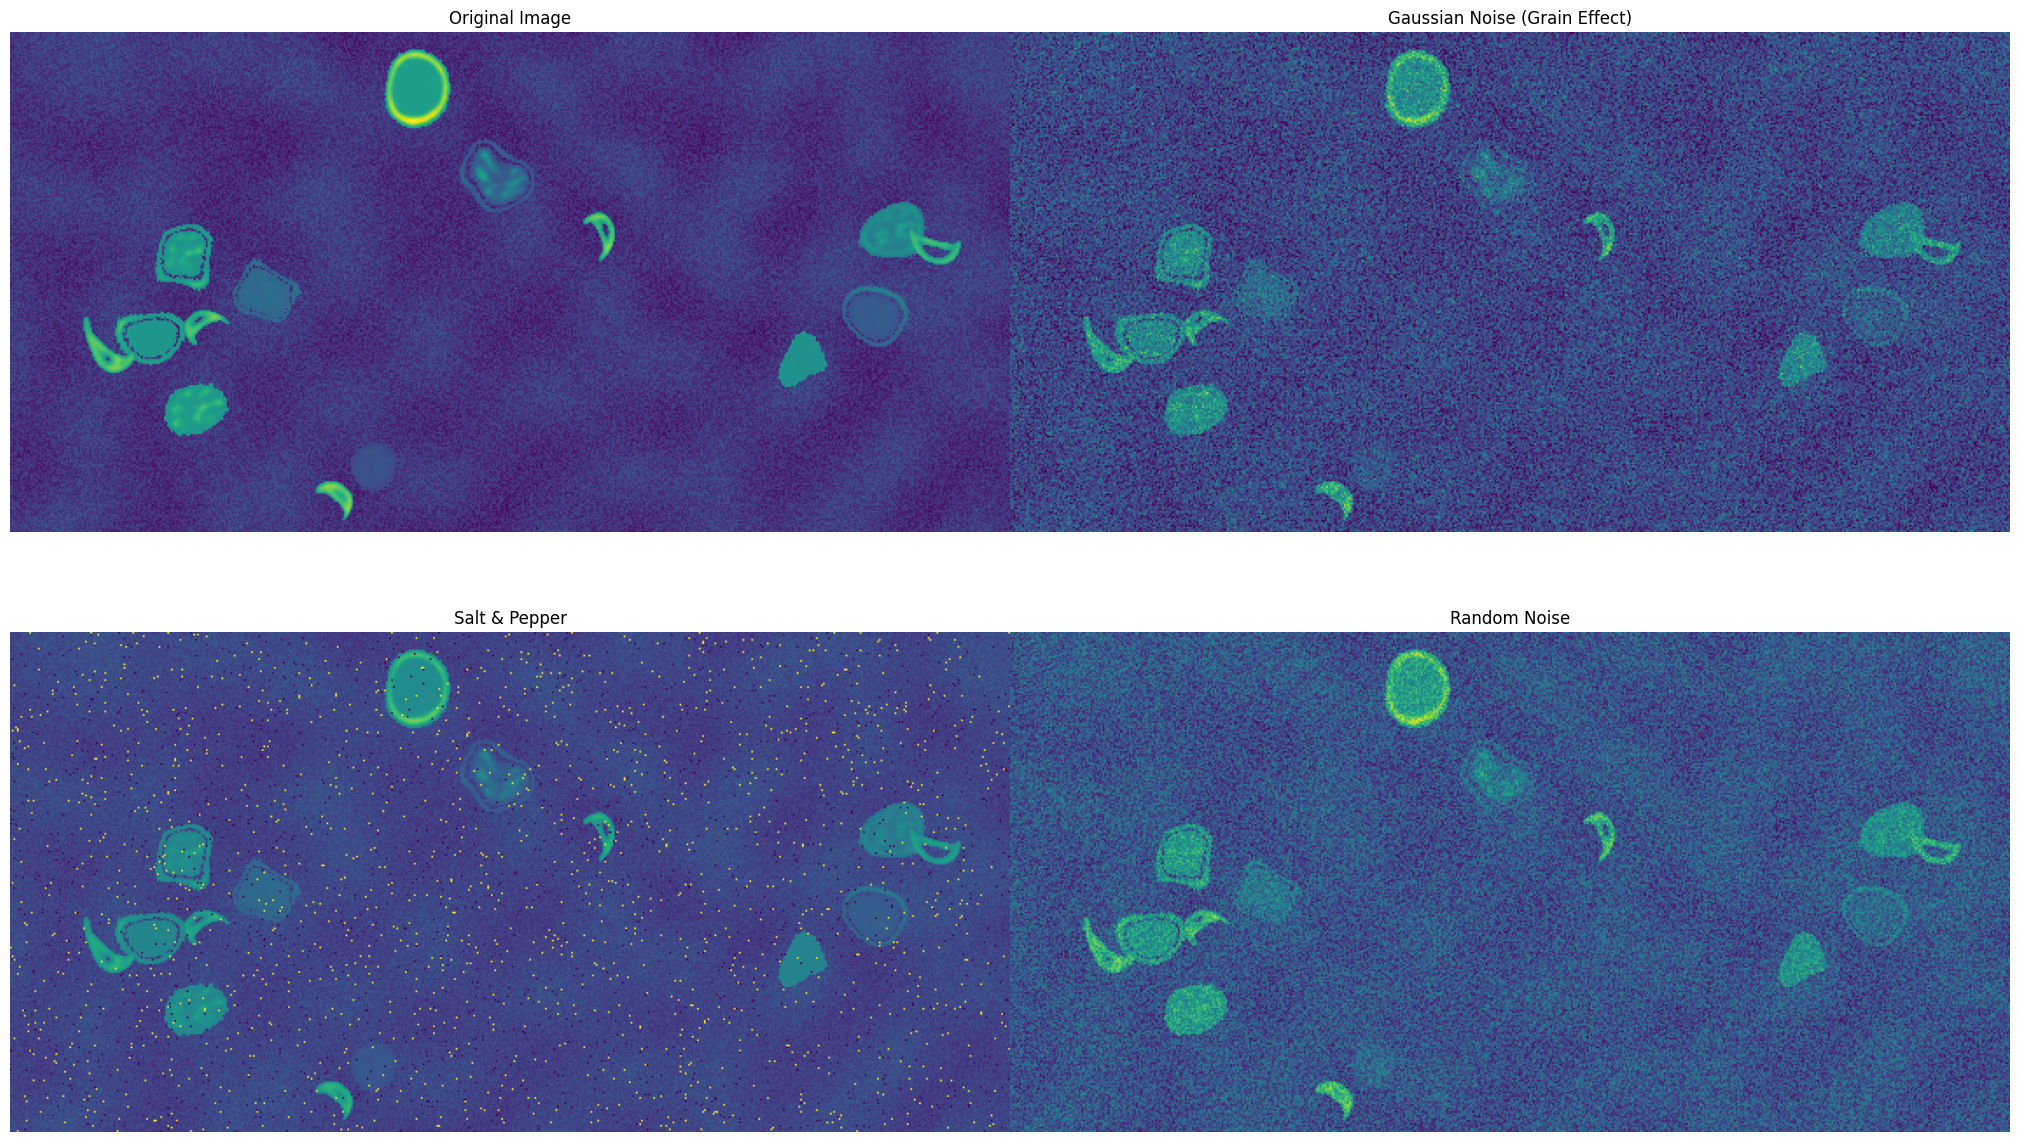

In [191]:
images = [os_path_join(PATH_SYNTHETIC_TRAIN, 'images', f) 
          for f in os_listdir(os_path_join(PATH_SYNTHETIC_TRAIN, 'images'))
          if f.endswith('npy')]
for image_name in images[:1]:
    image = np.load(image_name)#images[np.random.randint(0, len(images))])
    noisy_image = add_gaussian_noise(image)
    
    # Display images
    fig = plt.figure(figsize=(20,12))
    fig.tight_layout()
    plt.subplot(2,2,1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(2,2,2)
    plt.imshow(noisy_image)
    plt.title('Gaussian Noise (Grain Effect)')
    plt.axis('off')

    plt.subplot(2,2, 3)
    plt.imshow(add_salt_pepper_noise(image))
    plt.title('Salt & Pepper')
    plt.axis('off')

    plt.subplot(2, 2,4)
    plt.imshow(add_random_noise(image))
    plt.title('Random Noise')
    plt.axis('off')

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    plt.show()

# Dataset creation

> 🔥 Will generate a new dataset **by removing all previously generated images.**



In [14]:
def mask_to_yolo_bbox(bbox, image_width, image_height):
    """
    Convert mask segmentation (polygon) to YOLO bounding box format.

    Parameters:
    -----------
    bbox : tuple(float, float, float, float)
        Bounding box to convert to YOLO, as (xmin, ymin, xmax, ymax)
    image_width : int
    image_height : int

    Returns:
    --------
    x_center: float
      x_center of bbox in scale 0-1 of image width
    y_center
      y_center of bbox in scale 0-1 of image height
    width
      width of bbox in scale 0-1 of image width
    height
      height of bbox in scale 0-1 of image height
    """

    # Unpack bounding box coordinates
    x_min, y_min, x_max, y_max = bbox

    # if one of the point is outside image => return None
    if x_min < 0 or y_min < 0 or x_max >= image_width or y_max >= image_height:
        return None

    # Calculate bounding box center
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    # Width and height
    width = (x_max - x_min)
    height = (y_max - y_min)

    # divide x_center and width by image width, and y_center and height by image height:
    x_center /= image_width
    y_center /= image_height
    width /= image_width
    height /= image_height

    return x_center, y_center, width, height

def get_random_mask_subset(masks, min_masks, max_masks):
    """
    Get a random sample of masks. Used to diversify slipeprs.
    """
    num_to_sample = random.randint(min_masks, max_masks)
    return random.sample(masks, num_to_sample)

In [39]:
# Dataset creation
os_makedirs(os_path_join(PATH_SYNTHETIC_TRAIN, 'images'), exist_ok=True)
os_makedirs(os_path_join(PATH_SYNTHETIC_TRAIN, 'labels'), exist_ok=True)
os_makedirs(os_path_join(PATH_SYNTHETIC_VAL, 'images'), exist_ok=True)
os_makedirs(os_path_join(PATH_SYNTHETIC_VAL, 'labels'), exist_ok=True)
os_makedirs(os_path_join(PATH_SYNTHETIC_TEST, 'images'), exist_ok=True)
os_makedirs(os_path_join(PATH_SYNTHETIC_TEST, 'labels'), exist_ok=True)

# Load slipper masks
slipper_masks = [
    np.array(Image.open(os_path_join(PATH_SLIPPERS,ifile))) 
    for ifile in os_listdir(PATH_SLIPPERS)]


def get_nb_cells(N):
    """
    Returns: nb random cells, nb croissants, nb slippers
    """
    assert N >= 4, "N must be at least 4 to satisfy constraints (type 1: 2 or 3, others ≥1)"
    
    # Step 1: Choose 2 or 3 for random cells
    type1 = random.choice([2, 3])
    
    # Step 2: Compute remaining to split between croissants and slippers
    remaining = N - type1

    # Step 3: Ensure both croissants and slippers get at least 2
    type2 = random.randint(2, remaining - 2)
    type3 = remaining - type2

    return type1, type2, type3

# =========================== 🔥🔥🔥🔥 ===================================
# 🔥 Uncommand the following loop will remove all previously generated images from disk
for folder in [os_path_join(PATH_SYNTHETIC_TRAIN, 'images'),
               os_path_join(PATH_SYNTHETIC_TRAIN, 'labels'),
               os_path_join(PATH_SYNTHETIC_VAL, 'images'),
               os_path_join(PATH_SYNTHETIC_VAL, 'labels'),
               os_path_join(PATH_SYNTHETIC_TEST, 'images'),
               os_path_join(PATH_SYNTHETIC_TEST, 'labels')]:
    for f in os_listdir(folder):
        if not os_path_isdir(os_path_join(folder, f)):
            os_remove(os_path_join(folder, f))
# ========================================================================

IMAGE_SIZE=(200, 100) # width, height
nb_images = 500
nb_images_test = 50 # added to nb_images
nb_images_val = 50 # added to nb_images

# Generated dataset will have each noise function
# represented equally.
noise_functions = [
    lambda x:x,
    add_gaussian_noise,
    add_salt_pepper_noise,
    add_random_noise
]

file_id = 0 # common to all splits, +1 after each saved image
for nb_image_split, save_folder in [
    (nb_images, PATH_SYNTHETIC_TRAIN),
    (nb_images_val, PATH_SYNTHETIC_VAL),
    (nb_images_test, PATH_SYNTHETIC_TEST)]:
    
    for image_id in tqdm(range(nb_image_split)):
        
        # Choose a noise function based on the id to have equal
        # number of noise
        if len(noise_functions) > nb_image_split:
            noise_function = lambda x:x
        else:
            noise_function = noise_functions[
                image_id // (nb_image_split // len(noise_functions)) % len(noise_functions)
            ]
                
        img = np.array(generate_noise_background(IMAGE_SIZE[0], IMAGE_SIZE[1])) # init img with background


        nr, nc, ns = get_nb_cells(10)
        
        # ==================== Random cells ===================
        for i in range(nc):
            # populate with non-croissant shapes
            cell, mask = generate_cell_image(
              IMAGE_SIZE[0], IMAGE_SIZE[1], 10, 8, 7
          )
            cell = np.where(mask, cell, 0)
            img, _ = overlay_cell_on_background(cell, img, threshold=np.random.randint(10, 50))
    
    
        # ==================== Croissant cells ===================
        for cell_id in range(nr):
    
            # Generate a cell image and place it on the background with random position
            cell = generate_bullet_cell(
                cell_canvas_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), 
                rotation_angle=180,
                outer_a=16, outer_b=12, inner_r=14, offset_lim=(-10, -5))
            img, (start_x, start_y, end_x, end_y) = overlay_cell_on_background(cell, img, threshold=60)
            # (start_x, start_y) is the top-left point of the cell in the full image.
    
            # Extract the bbox of the cell in the cell-image coordinate system.
            mask = cell > 0
            bbox = find_bounding_box(mask)
            if bbox is None:
                continue
    
            xmin, ymin, xmax, ymax = bbox
            xmin += start_x
            xmax += start_x
            ymin += start_y
            ymax += start_y
    
            bbox = mask_to_yolo_bbox((start_x, start_y, end_x, end_y), img.shape[1], img.shape[0]) # needs w, h
            if bbox is None:
                continue
    
            class_id = 0
    
            with open(os_path_join(save_folder, 'labels', f'{file_id:04d}.txt'), "a") as label_file:
                label_file.write(f"{class_id} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
    


        # ==================== Slipper cells ===================
        selected_slippers = get_random_mask_subset(slipper_masks, ns, ns)
        for mask in selected_slippers:
            slipper = fill_mask_with_slipper(
                upscale_mask(mask, 2), 
                rotation_angle=180
            )
            img, (start_x, start_y, end_x, end_y) = overlay_cell_on_background(slipper, img, threshold=60)
    
    
            bbox = mask_to_yolo_bbox((start_x, start_y, end_x, end_y), img.shape[1], img.shape[0]) # needs w, h
            if bbox is None:
                continue
            with open(os_path_join(save_folder, 'labels', f'{file_id:04d}.txt'), "a") as label_file:
                label_file.write(f"1 {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
            
            
        
            
        #Image.fromarray(img).show()

        img = noise_function(img.astype(np.float32)/255.0)
        img *= 255.0
        img = img.astype(np.uint8)
        
        Image.fromarray(img).save(os_path_join(save_folder, 'images', f'{file_id:04d}.png'))
        file_id += 1
        

100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.99it/s]


In [42]:
# make a zip of the dataset
import shutil
shutil.make_archive('synthetic_dataset', 'zip', PATH_SYNTHETIC)

'/home/alex/dev/python/tx_rbc/tx_shared/notebooks/synthetic_dataset.zip'

## Test dataset: demo images and bbox

The following will show generated images and the bounding boxes for parachutes.

../data/synthetic/train/images
Showing file 0480.png
Image height x width is : 100 200 . Total image-file shape is :  (100, 200)
0.5575 0.395 0.175 0.27 => 94 129 26 53
0.115 0.495 0.14 0.33 => 9 37 32 66
0.1925 0.765 0.185 0.31 => 20 57 61 92
0.4325 0.4 0.125 0.56 => 74 99 12 68
0.875 0.23 0.16 0.46 => 159 191 0 46
0.3825 0.59 0.135 0.54 => 63 90 31 86


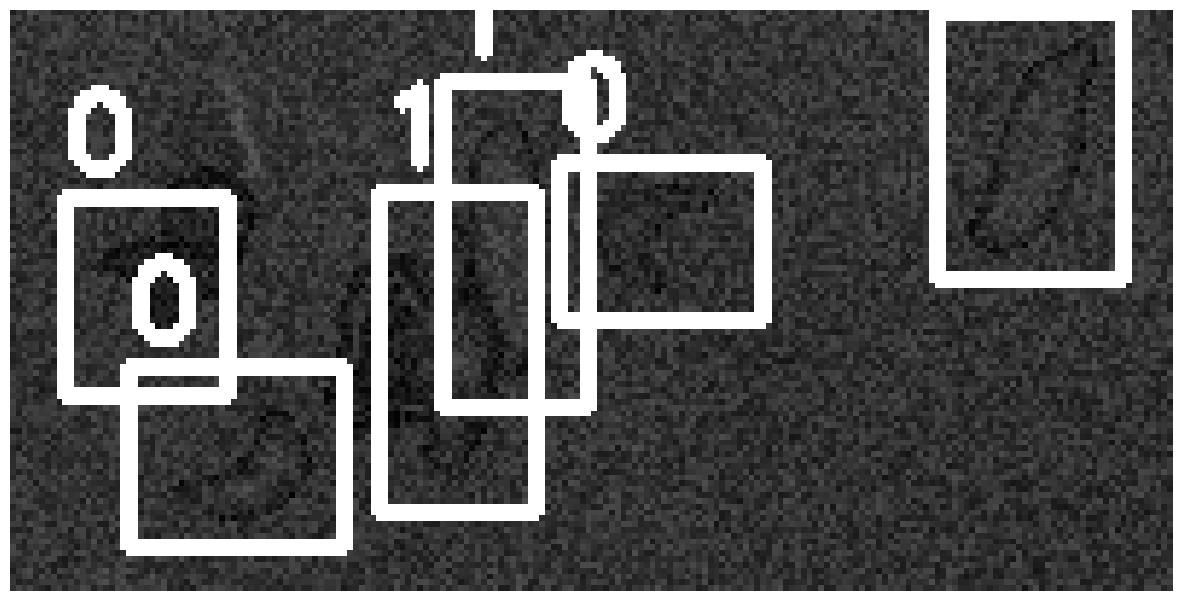

Showing file 0127.png
Image height x width is : 100 200 . Total image-file shape is :  (100, 200)
0.375 0.195 0.16 0.23 => 59 91 8 31
0.5 0.385 0.16 0.33 => 84 115 22 55
0.6925 0.82 0.145 0.28 => 124 153 68 96
0.7775 0.25 0.235 0.28 => 131 179 10 39
0.6575 0.435 0.135 0.49 => 118 145 19 68


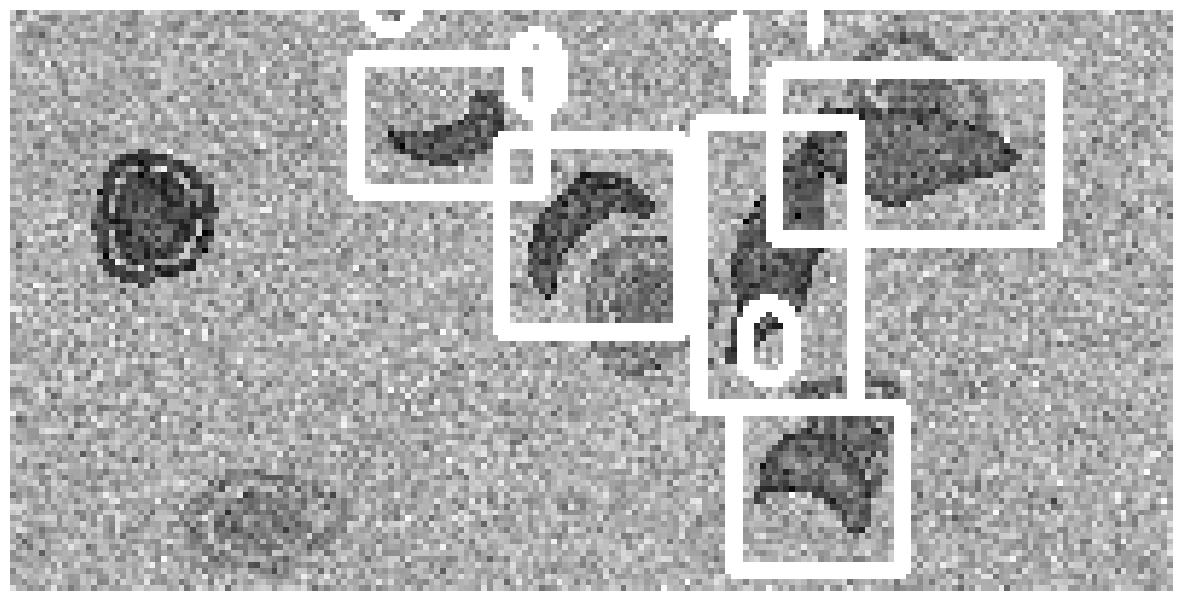

Showing file 0386.png
Image height x width is : 100 200 . Total image-file shape is :  (100, 200)
0.855 0.375 0.17 0.33 => 154 188 21 54
0.8875 0.64 0.195 0.32 => 157 197 48 80
0.1275 0.42 0.155 0.36 => 10 41 24 60
0.4175 0.65 0.215 0.38 => 62 105 46 84
0.865 0.26 0.22 0.3 => 151 195 11 41
0.2525 0.25 0.225 0.36 => 28 73 7 43
0.275 0.38 0.21 0.38 => 34 76 19 57


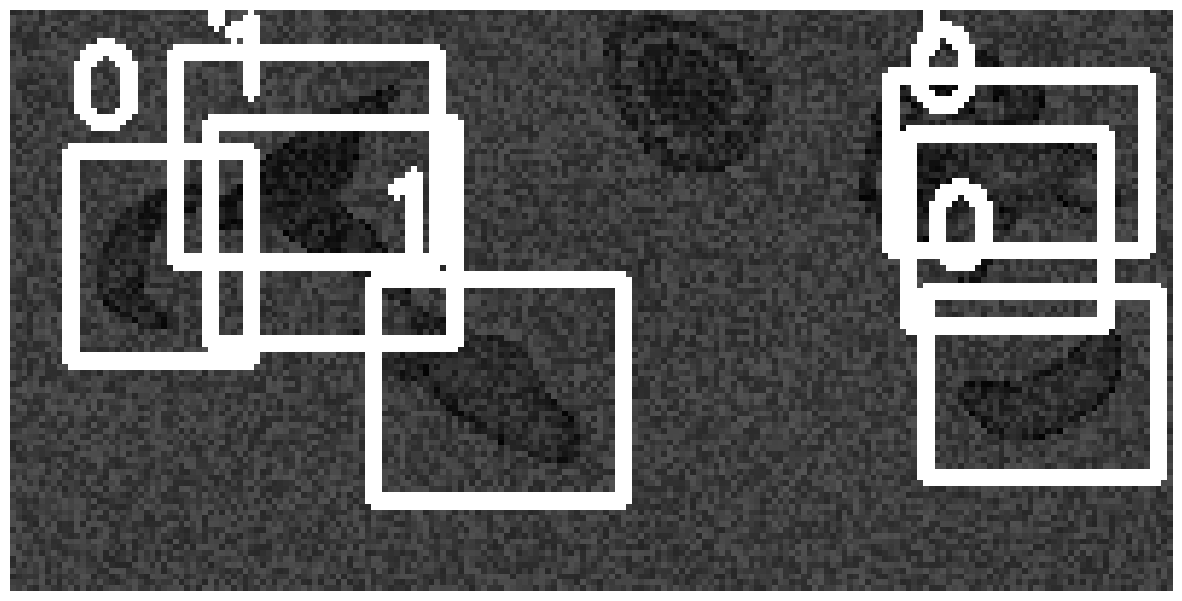

Showing file 0366.png
Image height x width is : 100 200 . Total image-file shape is :  (100, 200)
0.55 0.41 0.2 0.34 => 90 130 23 57
0.39 0.56 0.14 0.32 => 64 92 40 72
0.64 0.45 0.19 0.42 => 109 147 24 66
0.6025 0.4 0.165 0.52 => 104 137 14 66


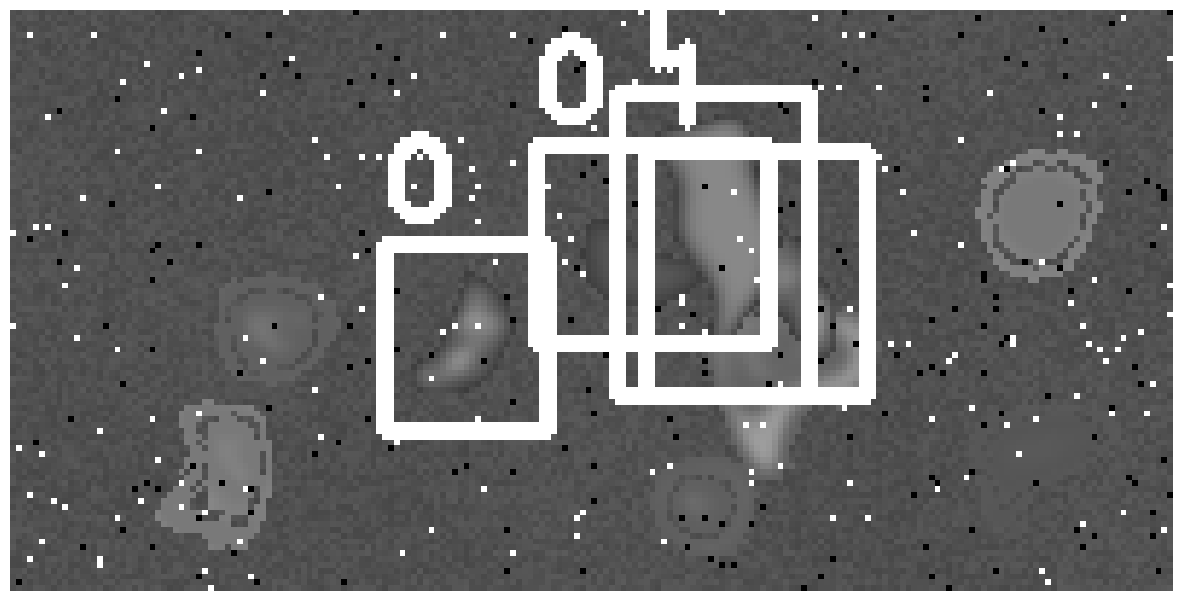

Showing file 0007.png
Image height x width is : 100 200 . Total image-file shape is :  (100, 200)
0.6325 0.315 0.195 0.33 => 106 146 15 48
0.8125 0.375 0.205 0.43 => 142 183 16 59
0.39 0.68 0.21 0.4 => 57 99 48 88
0.09 0.285 0.15 0.43 => 3 32 6 50


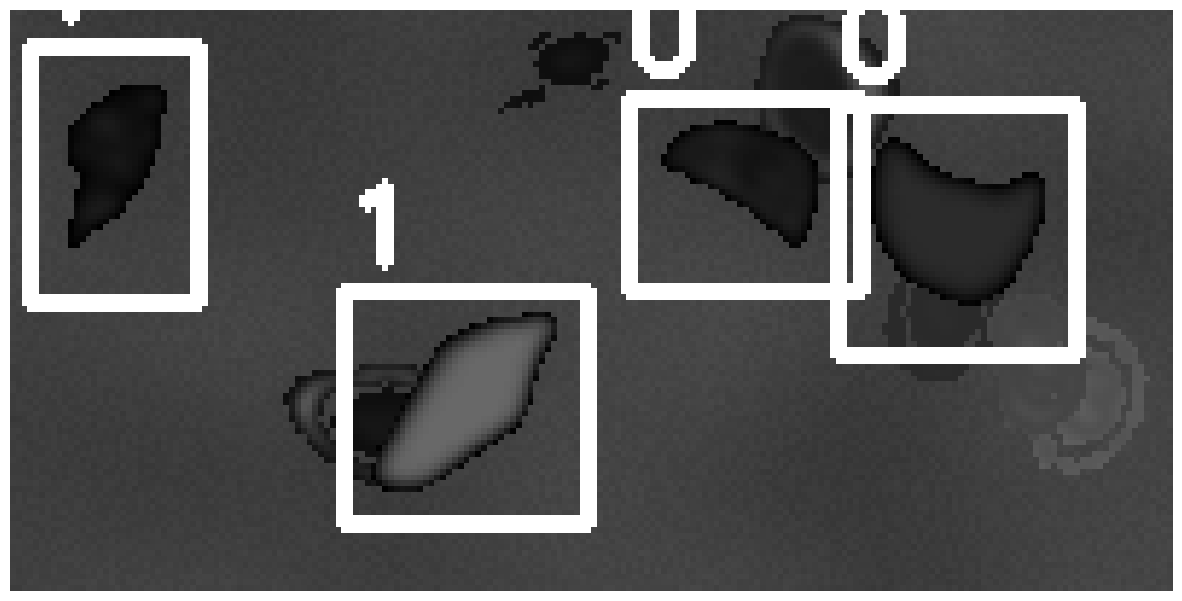

Showing file 0192.png
Image height x width is : 100 200 . Total image-file shape is :  (100, 200)
0.7375 0.535 0.155 0.33 => 132 163 37 70
0.17 0.265 0.2 0.33 => 14 54 10 43
0.1025 0.575 0.195 0.29 => 0 40 42 72
0.6825 0.455 0.185 0.39 => 118 155 26 65
0.3875 0.475 0.145 0.47 => 63 92 24 71
0.4275 0.225 0.215 0.31 => 64 107 7 38


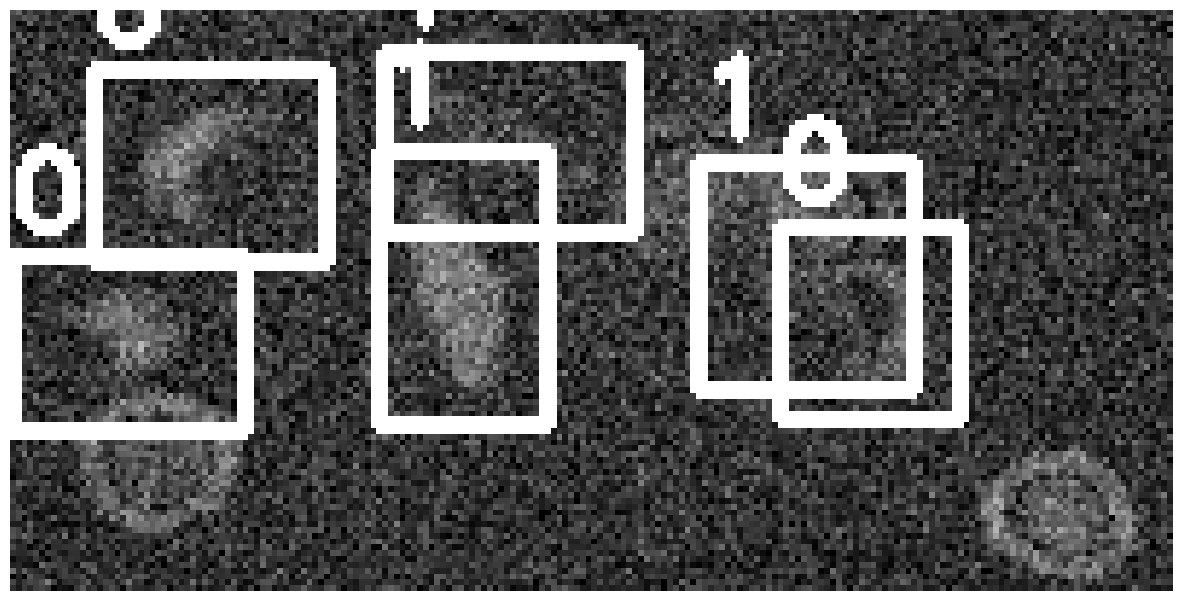

Showing file 0157.png
Image height x width is : 100 200 . Total image-file shape is :  (100, 200)
0.415 0.27 0.19 0.32 => 63 102 11 43
0.62 0.185 0.22 0.25 => 102 146 6 31
0.755 0.3 0.11 0.44 => 140 162 7 52
0.1725 0.31 0.175 0.46 => 17 52 7 54


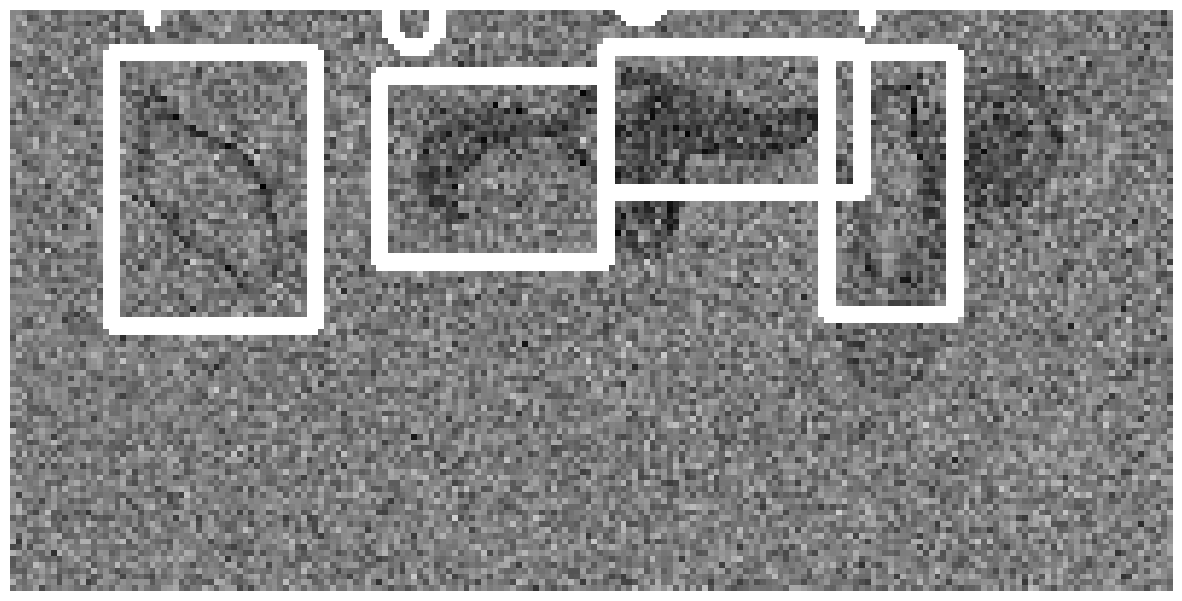

Showing file 0052.png
Image height x width is : 100 200 . Total image-file shape is :  (100, 200)
0.7475 0.74 0.175 0.26 => 132 167 61 87
0.87 0.67 0.17 0.26 => 157 191 54 80
0.71 0.26 0.25 0.3 => 117 167 11 41
0.1925 0.72 0.205 0.34 => 18 59 54 89
0.21 0.27 0.2 0.3 => 21 62 12 42


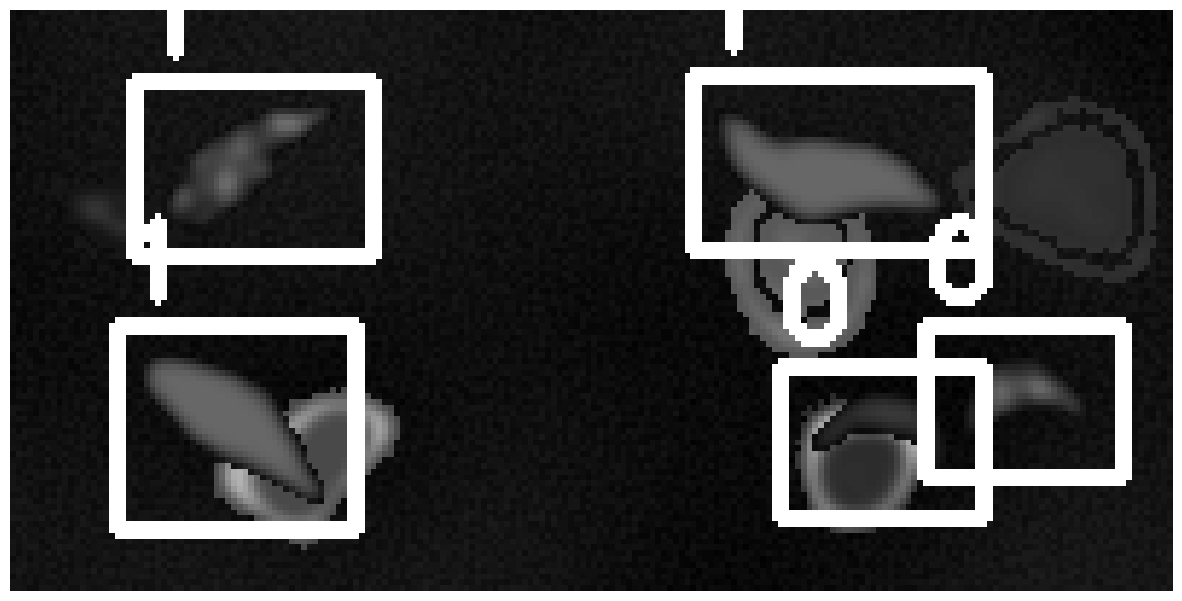

Showing file 0248.png
Image height x width is : 100 200 . Total image-file shape is :  (100, 200)
0.56 0.615 0.18 0.35 => 94 130 44 79
0.1625 0.785 0.195 0.33 => 13 52 62 95
0.8075 0.665 0.195 0.29 => 142 181 52 81
0.8075 0.455 0.175 0.49 => 144 179 21 70
0.5175 0.58 0.235 0.38 => 80 127 38 77


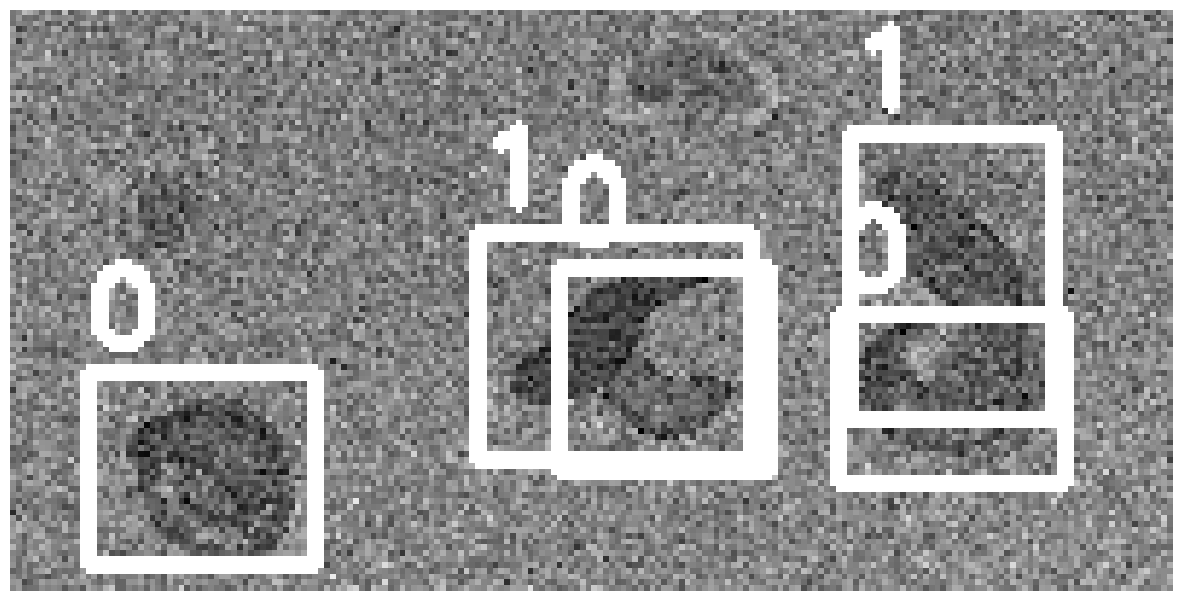

Showing file 0142.png
Image height x width is : 100 200 . Total image-file shape is :  (100, 200)
0.2625 0.38 0.235 0.3 => 29 76 23 53
0.7125 0.25 0.195 0.28 => 123 162 10 39
0.7625 0.39 0.225 0.28 => 129 175 25 53
0.4625 0.385 0.195 0.37 => 73 112 20 57
0.2725 0.615 0.135 0.53 => 41 68 35 88
0.5125 0.78 0.245 0.26 => 77 127 65 91
0.1425 0.685 0.215 0.39 => 6 50 49 88
0.3375 0.395 0.125 0.49 => 55 80 15 64


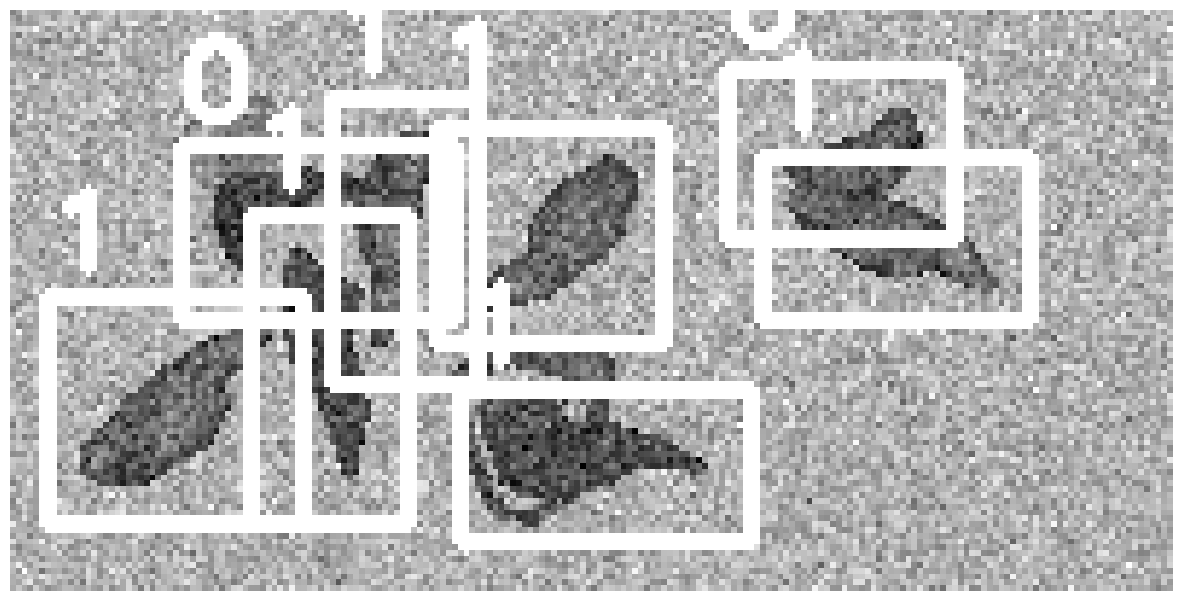

In [41]:
def draw_yolo_bboxes(root_path, N=5):
    images_path = os_path_join(root_path, "images")
    labels_path = os_path_join(root_path, "labels")

    image_files = sorted([f for f in os_listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg', 'npy'))])
    print(os_path_join(os_path_expanduser(root_path), "images"))
    random.shuffle(image_files)

    for img_file in image_files[:N]:
        print('Showing file', img_file)
        img_path = os_path_join(images_path, img_file)
        label_path = os_path_join(labels_path, os_path_splitext(img_file)[0] + ".txt")

        image = cv2.imread(img_path)
        #image = np.load(img_path) * 255.0
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to RGB for Matplotlib
        #cv2.cvtColor(image, cv2.COLOR_BGR2GRAY
        h, w = image.shape
        print('Image height x width is :', h, w, '. Total image-file shape is : ', image.shape)

        if os_path_exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    data = line.strip().split()
                    class_id = int(data[0])
                    x_center, y_center, width, height = map(float, data[1:])

                    # Convert YOLO format to pixel coordinates
                    x1 = int((x_center - width / 2)*w )
                    y1 = int((y_center - height / 2)*h )
                    x2 = int((x_center + width / 2)*w )
                    y2 = int((y_center + height / 2)*h )

                    print(x_center, y_center, width, height, '=>', x1, x2, y1, y2)

                    # Draw bounding box
                    color = (255, 0, 0)  # Red color
                    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(image, str(class_id), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        plt.figure(figsize=(15, 15))
        plt.imshow(image, cmap='gray')
        plt.axis("off")
        plt.show()

draw_yolo_bboxes(os_path_expanduser(PATH_SYNTHETIC_TRAIN), N=10)